In [1]:
import jax.numpy as np
import jax.random as jr

import matplotlib.pyplot as plt
import seaborn as sns

from ssm.utils import random_rotation
from ssm.slds.models import GaussianSLDS
from ssm.plots import gradient_cmap

In [2]:
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink"
    ]


colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

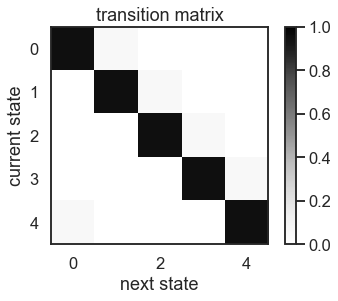

In [3]:
# Make a transition matrix
num_states = 5
latent_dim = 2
data_dim = 10
num_timesteps = 10000

# initialize parameters
initial_state_probs = np.ones(num_states) / num_states
initial_state_mean = np.zeros((latent_dim))
initial_state_scale_tril = np.eye(latent_dim)

transition_probs = (np.arange(num_states)**10).astype(float)
transition_probs /= transition_probs.sum()
transition_matrix = np.zeros((num_states, num_states))
for k, p in enumerate(transition_probs[::-1]):
    transition_matrix += np.roll(p * np.eye(num_states), k, axis=1)
    
plt.imshow(transition_matrix, vmin=0, vmax=1, cmap="Greys")
plt.xlabel("next state")
plt.ylabel("current state")
plt.title("transition matrix")
plt.colorbar()

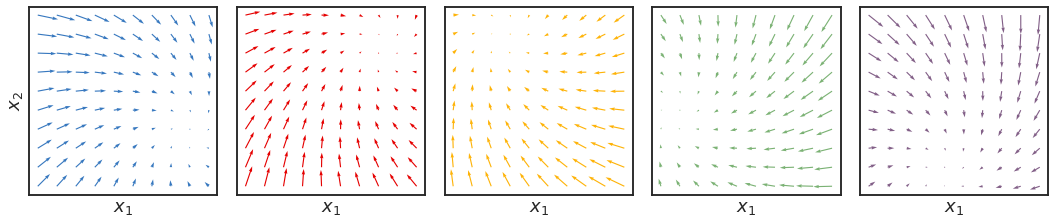

In [4]:

keys = jr.split(jr.PRNGKey(0), num_states)
theta = np.pi / 25 # rotational frequency
angles = np.linspace(0, 2 * np.pi, num_states, endpoint=False)
biases = np.column_stack([np.cos(angles), np.sin(angles), np.zeros((num_states, latent_dim - 2))])
dynamics_weights = np.array([0.8 * random_rotation(key, latent_dim, theta=theta) for key in keys])
dynamics_biases = np.column_stack([np.cos(angles), np.sin(angles), np.zeros((num_states, latent_dim - 2))])
dynamics_scale_trils = np.tile(np.sqrt(0.001) * np.eye(latent_dim), (num_states, 1, 1))


# Compute the stationary points
stationary_points = np.linalg.solve(np.eye(latent_dim) - dynamics_weights, dynamics_biases)

if latent_dim == 2:
    lim = 5
    x = np.linspace(-lim, lim, 10)
    y = np.linspace(-lim, lim, 10)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    fig, axs = plt.subplots(1, num_states, figsize=(3 * num_states, 6))
    for k in range(num_states):
        A, b = dynamics_weights[k], dynamics_biases[k]
        dxydt_m = xy.dot(A.T) + b - xy
        axs[k].quiver(xy[:, 0], xy[:, 1],
                    dxydt_m[:, 0], dxydt_m[:, 1],
                    color=colors[k % len(colors)])

        
        axs[k].set_xlabel('$x_1$')
        axs[k].set_xticks([])
        if k == 0:
            axs[k].set_ylabel("$x_2$")
        axs[k].set_yticks([])
        axs[k].set_aspect("equal")
                        

    plt.tight_layout()

In [5]:
emissions_weights = jr.normal(jr.PRNGKey(1), (num_states, data_dim, latent_dim))
emissions_biases = np.zeros((num_states, data_dim))
emissions_scale_trils = np.tile(0.1 * np.eye(data_dim), (num_states, 1, 1))

In [6]:
slds = GaussianSLDS(num_states,
                    latent_dim,
                    data_dim,
                    initial_state_probs,
                    initial_state_mean,
                    initial_state_scale_tril,
                    transition_matrix,
                    dynamics_weights,
                    dynamics_biases,
                    dynamics_scale_trils,
                    emissions_weights,
                    emissions_biases,
                    emissions_scale_trils)

In [7]:
true_states, data = slds.sample(jr.PRNGKey(3), num_timesteps)
true_x = true_states["continuous"]
true_z = true_states["discrete"]


Text(0, 0.5, '$x_2$')

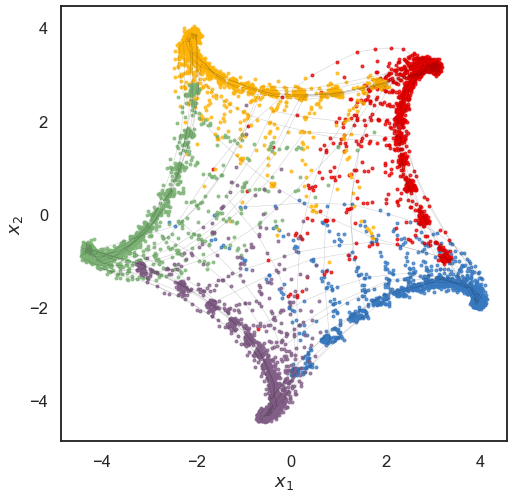

In [8]:
fig = plt.figure(figsize=(8, 8))
for k in range(num_states):
    plt.plot(*true_x[true_z==k].T, 'o', color=colors[k],
         alpha=0.75, markersize=3)
    
plt.plot(*true_x[:1000].T, '-k', lw=0.5, alpha=0.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
# plt.gca().set_aspect("equal")

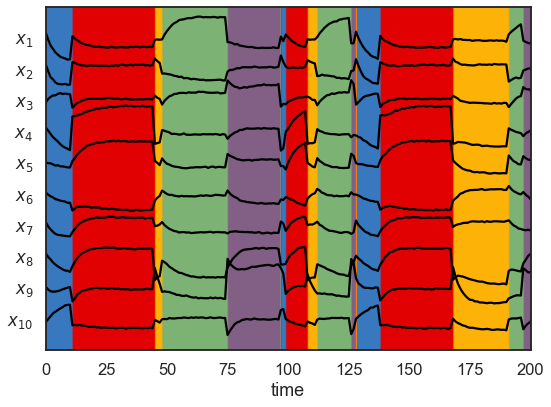

In [9]:
# Plot the data and the smoothed data
plot_slice = (0, 200)
lim = 1.05 * abs(data).max()
plt.figure(figsize=(8, 6))
plt.imshow(true_z[None, :],
           aspect="auto",
           cmap=cmap,
           vmin=0,
           vmax=len(colors)-1,
           extent=(0, num_timesteps, -(data_dim)*lim, lim))


for d in range(data_dim):
    plt.plot(data[:,d] - lim * d, '-k')

plt.xlim(plot_slice)
plt.xlabel("time")
plt.yticks(-lim * np.arange(data_dim), ["$y_{{{}}}$".format(d+1) for d in range(data_dim)])

plt.tight_layout()


In [10]:
slds.log_probability(true_states, data) / num_timesteps

DeviceArray(12.681237, dtype=float32)